# Recommender systems

Recommender systems are one of the most successful and widespread application of machine learning technologies in business. You can find large scale recommender systems in retail, video on demand, or music streaming etc…

## data loading

In [23]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('ggplot')

%matplotlib inline

In [1]:
import pandas as pd

ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [2]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.000026e+07,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00,1.100918e+09
std,4.003863e+04,1.978948e+04,1.051989e+00,1.621694e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,3.439500e+04,9.020000e+02,3.000000e+00,9.667977e+08
50%,6.914100e+04,2.167000e+03,3.500000e+00,1.103556e+09
75%,1.036370e+05,4.770000e+03,4.000000e+00,1.225642e+09
max,1.384930e+05,1.312620e+05,5.000000e+00,1.427784e+09


In [3]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
tags = pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [4]:
full_df = ratings.merge(movies,on='movieId',how='left')
print(full_df.shape)
full_df.head()

(20000263, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
full_df = full_df.iloc[0:100000]

# Algorithms

## KNN

### data preperation

In [69]:
print('shape of different tables :----------------------------------------------->')
print('rating :',ratings.shape)
print('movies :',movies.shape)
print('tags :',tags.shape)
print('full_df :',full_df.shape)

shape of different tables :----------------------------------------------->
rating : (20000263, 4)
movies : (27278, 3)
tags : (465564, 4)
full_df : (100000, 7)


In [70]:
ratings.userId.nunique()

138493

#### counts of each ratings

In [71]:
pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])

,count
rating,
0.5,239125
1.0,680732
1.5,279252
2.0,1430997
2.5,883398
3.0,4291193
3.5,2200156
4.0,5561926
4.5,1534824


In [10]:
dates_outlook = pd.to_datetime(pd.Series(full_df.timestamp),unit='s')
full_df['date'] = dates_outlook  
full_df.head()

,userId,movieId,rating,timestamp,title,genres,date
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy,2005-04-02 23:53:47
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,2005-04-02 23:31:16
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,2005-04-02 23:33:39
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2005-04-02 23:32:07
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,2005-04-02 23:29:40


In [11]:
full_df.corr()

,userId,movieId,rating,timestamp
userId,1.000000,0.033281,0.002227,0.055122
movieId,0.033281,1.000000,0.006442,0.466570
rating,0.002227,0.006442,1.000000,-0.002767
timestamp,0.055122,0.466570,-0.002767,1.000000


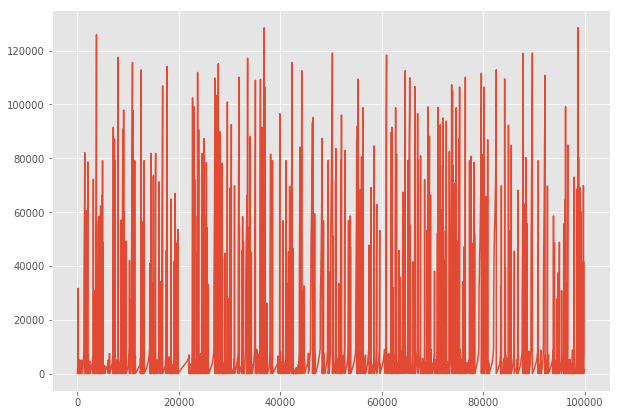

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
full_df.movieId.plot()
plt.show()

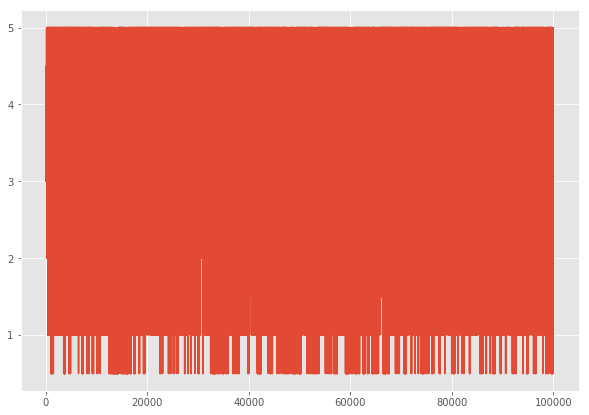

In [28]:
full_df.rating.plot()

In [12]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = full_df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

In [33]:
from scipy.sparse import csr_matrix

# pivot and create movie-user matrix
movie_user_mat = full_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create a dictionary mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [41]:
movie_user_mat

userId,1,2,3,4,5,6,7,8,9,10,...,693,694,695,696,697,698,699,700,701,702
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,4.5,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,3.5,0.0,2.0,0.0,0.0,0.0
6,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
movie_to_idx


{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 

### Model

In [34]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)


In [35]:
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

### Use this trained model for movie recommendation 

In [67]:
def search_movie_index(mapper, fav_movie, verbose=True):
    ## return the closest match via fuzzy ratio. If no match found, return None ##
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])
    if not match_tuple:
        print('No match is found !!!')
        return
    if verbose:
        print('Found possible matches : {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[len(match_tuple)-1][1]



def recommend(model_knn, data, mapper, fav_movie, n_recommendations):
    
    ##return top n similar movie recommendations based on user's input movie ##
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = search_movie_index(mapper, fav_movie, verbose=True)
    # inference
    
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Our Recommendations : ')
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance = {2}'.format(i+1, reverse_mapper[idx], dist))

In [72]:

my_favorite = 'rush hour'

recommend(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: rush hour
Found possible matches : ['Rush Hour 2 (2001)', 'Rush Hour 3 (2007)', 'Rush Hour (1998)']

......

Our Recommendations : 
1: Enemy of the State (1998), with distance = 0.5442989485000413
2: Tomorrow Never Dies (1997), with distance = 0.5371797620434595
3: Con Air (1997), with distance = 0.5145972066696396
4: Payback (1999), with distance = 0.5110877021776654
5: Negotiator, The (1998), with distance = 0.5053107825269095
6: Mummy, The (1999), with distance = 0.4992448581944702
7: Die Hard 2 (1990), with distance = 0.49369411350512626
8: Face/Off (1997), with distance = 0.46983184220384344
9: Rush Hour 2 (2001), with distance = 0.45014136875729527
10: Blade (1998), with distance = 0.44600140965946955
